# Dpi Setting

In [103]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100 # 300

In [104]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
from package_sampling.sampling import up_tille, up_brewer, up_systematic, up_max_entropy
from package_sampling.utils import inclusion_probabilities


In [106]:
import os

print(os.getcwd())

/home/divar/projects/graphical-sampling


In [107]:
import os
os.chdir('/home/divar/projects/graphical-sampling')

### Dependencies

### Python

In [108]:
# !pip install -q git+https://github.com/mehdimhb/geometric-sampling@dev
# !pip install git+https://github.com/mehdimhb/geometric-sampling@legacy-measure

In [109]:
!apt-get install -y r-base
#!pip install -q rpy2 tqdm


E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [110]:
from rpy2.robjects.packages import importr

import numpy as np
from rpy2.robjects import numpy2ri, default_converter, globalenv
from rpy2.robjects.conversion import localconverter

In [111]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


### R

In [112]:
%%R

#library(spcosa)
#ibrary(spsurvey)
if(!require(WaveSampling)){
    install.packages("WaveSampling")
    library(WaveSampling)
}
if(!require(sampling)){
    install.packages("sampling")
    library(sampling)
}
if(!require(BalancedSampling)){
    install.packages("BalancedSampling")
    library(BalancedSampling)
}

### Imports

In [113]:
import matplotlib as mpl
import numpy as np
from rpy2.robjects import r, numpy2ri
import rpy2.robjects as ro
from matplotlib import pyplot as plt
from itertools import combinations
from collections import OrderedDict
import pandas as pd
import geometric_sampling as gs
from tqdm import tqdm
from tqdm.contrib import tenumerate
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

#numpy2ri.activate()

rng = gs.random.rng()

## Functions

### Functions

In [114]:
autumn_cmap = plt.get_cmap('autumn')
plasma_cmap = plt.get_cmap('plasma')

def get_autumn_colors(n_clusters):
    """Returns n_clusters colors from the autumn colormap."""
    colors = autumn_cmap(np.linspace(0.15, 0.95, n_clusters))
    return colors

def get_plasma_colors(n_clusters):
    """Returns n_clusters colors from the plasma colormap."""
    colors = plasma_cmap(np.linspace(0.15, 0.95, n_clusters))
    return colors

# Example usage:
n = 10  # Number of clusters
n_clusters = n
import matplotlib.pyplot as plt
import numpy as np

def lighten_color(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = np.array(mc.to_rgb(c))
    white = np.array([1, 1, 1])
    return tuple((1 - amount) * c + amount * white)

n_clusters = n
base_colors = plt.cm.plasma(np.linspace(0, 1, n_clusters))
light_colors = [lighten_color(col, 0.5) for col in base_colors]

autumn_colors = get_autumn_colors(n_clusters)
plasma_colors = get_plasma_colors(n_clusters)
plasma_colors = light_colors

In [115]:
def plot_convex_hull(points, ax, color, alpha=0.33, edge_color="gray", line_width=0.6):
    """Plot convex hull safely. Always returns (ax, hull or None)."""
    if len(points) < 3:
        return ax, None
    try:
        hull = ConvexHull(points)
        polygon = Polygon(
            points[hull.vertices],
            closed=True,
            facecolor=color,
            alpha=alpha,
            edgecolor=edge_color,
            lw=line_width,
            zorder=1
        )
        ax.add_patch(polygon)
        return ax, hull
    except QhullError:
        # Can't make hull, skip
        return ax, None


# Simulations

## Methods

In [116]:
def scores(coords, probs, n, N, sample_idx, split_size, density_measure=None):
    assert len(coords) == len(probs) == N
    assert len(sample_idx) == n
    sample_mask = np.zeros(N, dtype=int)
    sample_mask[sample_idx] = 1

    with localconverter(default_converter + numpy2ri.converter):
        globalenv['sample_mask'] = sample_mask
        globalenv['sample_idx'] = sample_idx + 1  # Or int(sample_idx + 1) if it's just one value
        globalenv['coords'] = coords
        globalenv['probs'] = probs
        globalenv['n'] = n
        globalenv['N'] = N

    r_code = """
W <- wpik(coords,probs)
W <- W - diag(diag(W))
diag(W) <- 0

ib_value <- tryCatch({
  IB(W, sample_mask)
}, error = function(e) { Inf })

sb_value <- tryCatch({
  sb(probs, coords, sample_idx)
}, error = function(e) { Inf })

sblb_value <- tryCatch({
  sblb(probs, coords, sample_idx)
}, error = function(e) { Inf })
"""
    ro.r(r_code)
    IB_value = ro.r("ib_value")[0]
    SB_value = ro.r("sb_value")[0]
    SBLB_value = ro.r("sblb_value")[0]
    if density_measure is None:
        scaled_coords = (coords - np.min(coords, axis=0)) / np.ptp(coords, axis=0)
        density_measure = gs.measure.Density(scaled_coords, probs, n, split_size=0.001)
    scores_val = density_measure.score(sample_idx.reshape(1, -1))
    return scores_val[0], IB_value, SBLB_value

In [117]:
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects import default_converter, numpy2ri
from rpy2.robjects.conversion import localconverter

def local_pivotal_sampler(coords, probs, n):
    def get_sample():
        with localconverter(default_converter + numpy2ri.converter):
            ro.globalenv['coords'] = coords
            ro.globalenv['probs'] = probs
        r_code = """
s <- lpm(probs, coords)
"""
        ro.r(r_code)
        with localconverter(default_converter + numpy2ri.converter):
            sample_idx = np.array(list(ro.r("s"))) - 1
        return sample_idx
    return get_sample

def k_means_sampler(coords, probs, n, n_zones, sort_method):
    def get_sample():
        sample = gs.sampling.KMeansSpatialSamplingSimple(
            coords, probs, n=n, n_zones=n_zones, sort_method=sort_method,
            tolerance=7, split_size=0.001
        ).sample(1)[0]
        return sample
    return get_sample

def random_sampler(coords, probs, n):
    def get_sample():
        return gs.sampling.RandomSampling(coords, probs, n=n).sample(1)[0]
    return get_sample

def upmaxentropy_sampler(probs, n):
    def get_sample():
        with localconverter(default_converter + numpy2ri.converter):
            ro.globalenv['probs'] = probs
        r_code = """
mask <- UPmaxentropy(probs)
"""
        ro.r(r_code)
        with localconverter(default_converter + numpy2ri.converter):
            mask = np.array(ro.r("mask"))
        if mask.dtype != np.bool_:
            mask = mask.astype(bool)
        sample_idx = np.where(mask)[0]
        return sample_idx
    return get_sample

def wave_sampler(coords, probs, n):
    def get_sample():
        with localconverter(default_converter + numpy2ri.converter):
            ro.globalenv['coords'] = coords
            ro.globalenv['probs'] = probs
        r_code = """
wave_mask <- wave(coords, probs)
"""
        ro.r(r_code)
        with localconverter(default_converter + numpy2ri.converter):
            mask = np.array(ro.r("wave_mask"))
        if mask.dtype != np.bool_:
            mask = mask.astype(bool)
        sample_idx = np.where(mask)[0]
        return sample_idx
    return get_sample

def find_samplers(coords, probs, n):
    samplers = {
        "K-Means (11_lexico)": k_means_sampler(coords, probs, n, (1, 1), "lexico"),
        "K-Means (11_random)": k_means_sampler(coords, probs, n, (1, 1), "random"),
        # "K-Means (22_lexico)": k_means_sampler(coords, probs, n, (2, 2), "lexico"),
        # "K-Means (22_random)": k_means_sampler(coords, probs, n, (2, 2), "random"),
        # "K-Means (33_lexico)": k_means_sampler(coords, probs, n, (3, 3), "lexico"),
        # "K-Means (33_random)": k_means_sampler(coords, probs, n, (3, 3), "random"),
        "K-Means (11_projection)": k_means_sampler(coords, probs, n, (1, 1), "projection"),
        "K-Means (11_distance_0)": k_means_sampler(coords, probs, n, (1, 1), "distance_0"),
        # "K-Means (22_projection)": k_means_sampler(coords, probs, n, (2, 2), "projection"),
        # "K-Means (22_distance_0)": k_means_sampler(coords, probs, n, (2, 2), "distance_0"),
        # "K-Means (33_lprojection)": k_means_sampler(coords, probs, n, (3, 3), "projection"),
        # "K-Means (33_distance_0)": k_means_sampler(coords, probs, n, (3, 3), "distance_0"),
        "K-Means (11_angel_0)": k_means_sampler(coords, probs, n, (1, 1), "angel_0"),
        # "K-Means (22_angel_0)": k_means_sampler(coords, probs, n, (2, 2), "angel_0"),
        # "K-Means (33_angel_0)": k_means_sampler(coords, probs, n, (3, 3), "angel_0"),
        "Local Pivotal": local_pivotal_sampler(coords, probs, n),
        # "Random": random_sampler(coords, probs, n),
        # "UPmaxentropy": upmaxentropy_sampler(probs, n),
        "Wave": wave_sampler(coords, probs, n)
    }
    return samplers

## Swiss

### Plot Swiss Data

In [118]:
import numpy as np
import pandas as pd

n = 4


# --- SEEDING for reproducibility ---
np.random.seed(42)

# --- PARAMS ---
# Target sample size
swiss_csv = '/home/divar/projects/graphical-sampling/Simulations/swiss.csv'

# Load your dataset
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

swiss_df_0 = pd.read_csv(swiss_csv)
coords = swiss_df_0[['COORD_X', 'COORD_Y']].values

# Cluster every row into 'reduced_data_size' clusters
reduced_data_size = 100
kmeans = KMeans(n_clusters=reduced_data_size, random_state=42)
labels = kmeans.fit_predict(coords)

# Find the point in each cluster that is closest to its centroid
closest_idxs = []
for i in range(reduced_data_size):
    cluster_points = np.where(labels == i)[0]
    if len(cluster_points) > 0:  # safe check, should always be true in KMeans
        centroid = kmeans.cluster_centers_[i]
        closest = cluster_points[np.argmin(np.linalg.norm(coords[cluster_points] - centroid, axis=1))]
        closest_idxs.append(closest)

# Now, select the original rows, **maintaining ALL columns**
swiss_df = swiss_df_0.iloc[closest_idxs].copy().reset_index(drop=True)  # don't reset_index!





# --- 1. Setup holders for all coordinates/probs/populations ---
populations = {}
probabilities = {}
pop_objs = {}


# Extract original x/y for clarity
xy = swiss_df[['COORD_X', 'COORD_Y']]
# scaled_xy = (xy - xy.min()) / (xy.max() - xy.min())
scaled_xy = xy
swiss_df[['x', 'y']] = scaled_xy
#meuse_df['x'] = round(meuse_df['x']/10000)
#meuse_df['y'] = round(meuse_df['y']/10000)
coords_swiss = swiss_df[['x', 'y']].to_numpy()
N_swiss = coords_swiss.shape[0]

area = swiss_df['AREA'].clip(1, 100)
# Assumes rng and inclusion_probabilities are defined in your environment
probs_swiss_eq = rng.equal_probabilities(n, N_swiss)
probs_swiss_uneq = inclusion_probabilities(area, n)

populations['swiss'] = coords_swiss
probabilities['swiss_eq'] = probs_swiss_eq
probabilities['swiss_uneq'] = probs_swiss_uneq

# --- 3. Create population objects based on meuse data only ---
hard = gs.sampling.KMeansSpatialSamplingSimple(
    coords_swiss, probs_swiss_eq, n=n, n_zones=(3, 3), tolerance=7, split_size=0.001)
pop_objs['swiss_eq'] = hard.popu

hard = gs.sampling.KMeansSpatialSamplingSimple(
    coords_swiss, probs_swiss_uneq, n=n, n_zones=(4, 4), tolerance=7, split_size=0.001)
pop_objs['swiss_uneq'] = hard.popu



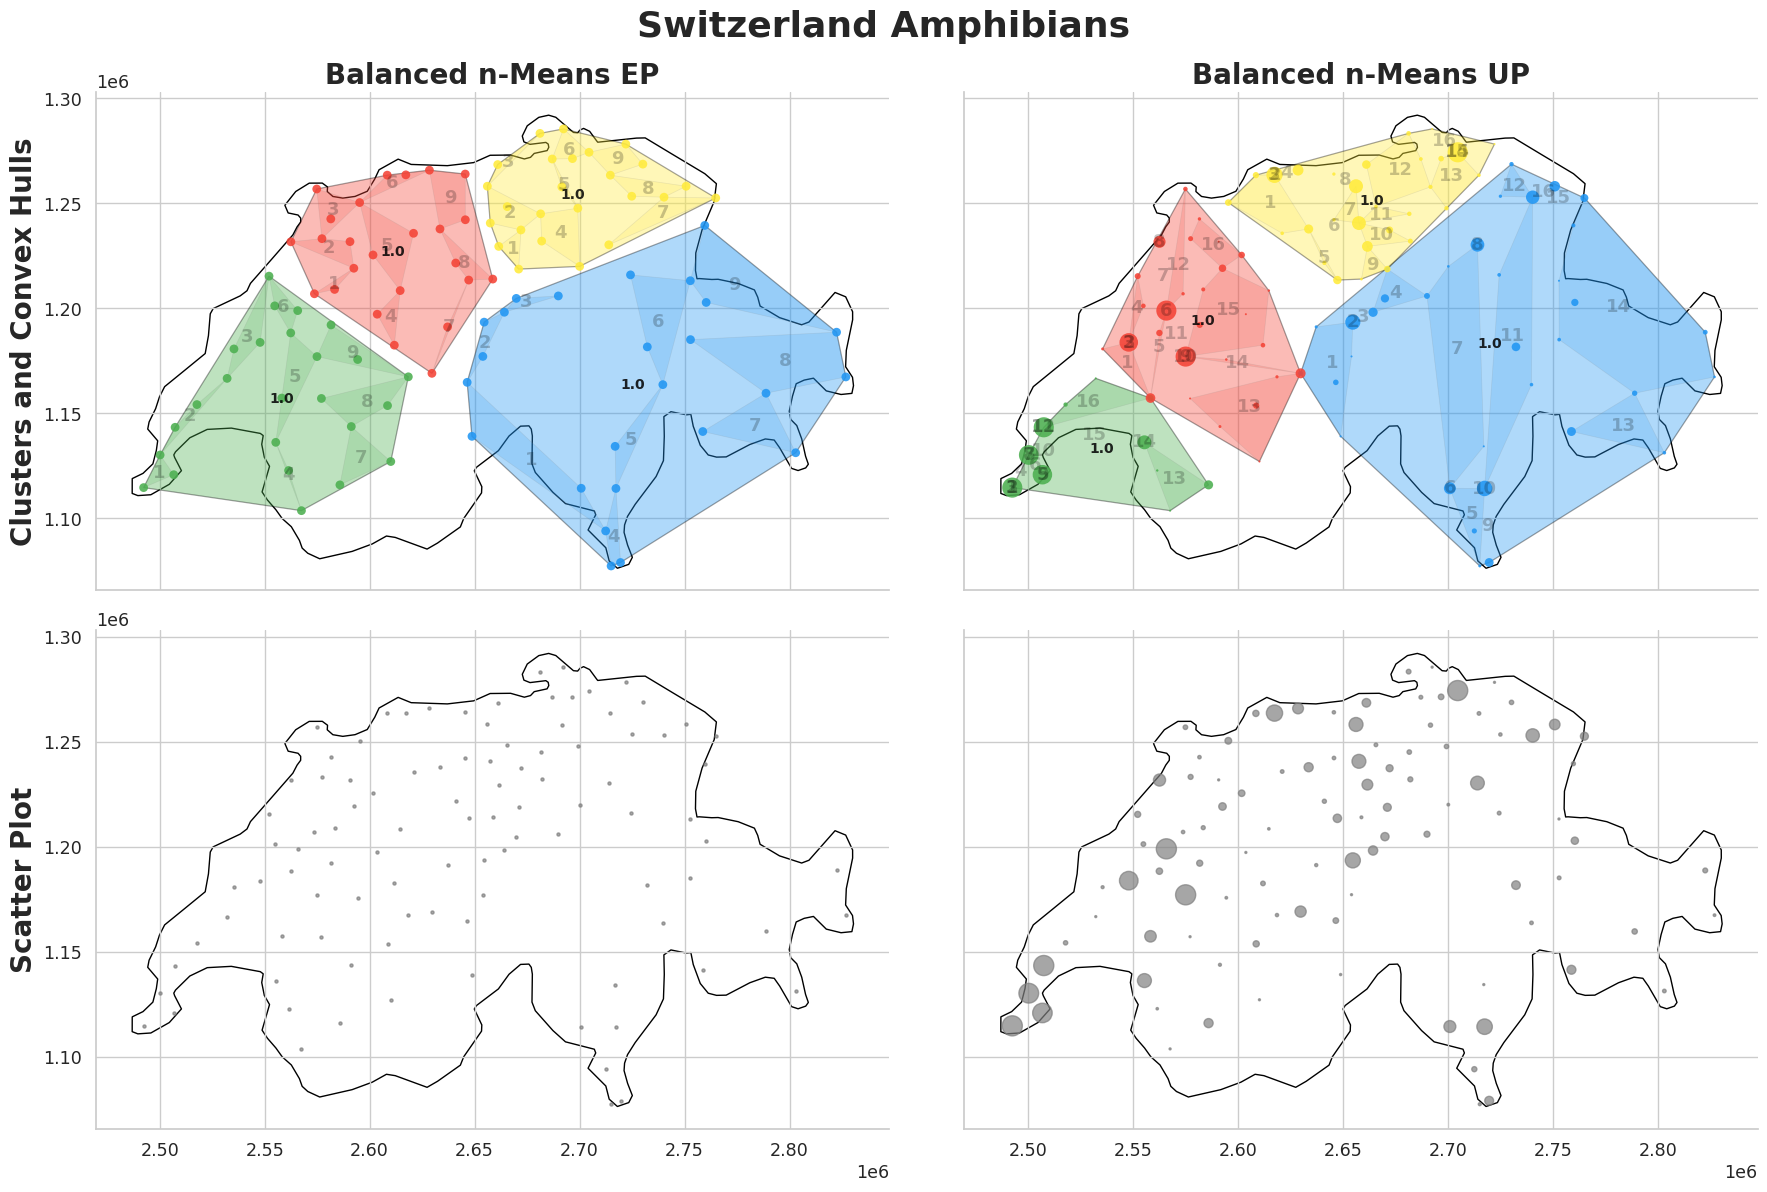

In [119]:
import matplotlib.pyplot as plt
import geopandas as gpd

swiss_shp = '/home/divar/Downloads/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp'

world = gpd.read_file(swiss_shp)
swiss_map = world[world['ADMIN'] == 'Switzerland'].to_crs(epsg=2056)

col_labels = [
    "Balanced n-Means EP",
    "Balanced n-Means UP"
]

fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharex=True, sharey=True)

for col, key in enumerate(['swiss_eq', 'swiss_uneq']):
    ax = axes[1, col]
    swiss_map.plot(ax=ax, color="white", edgecolor="black", linewidth=1.0, zorder=0)
    pops = pop_objs[key]
    coords = pops.coords
    probs = pops.probs

    if key == 'swiss_eq':
        # Uniform size
        s = 5
        ax.scatter(coords[:, 0], coords[:, 1], c="gray", s=s, alpha=0.7, zorder=2)
    else:  # 'swiss_uneq'
        # Size proportional to probs, clipped for visibility
        s = probs * 1000  # You can adjust scale/clipping as needed
        ax.scatter(coords[:, 0], coords[:, 1], c="gray", s=s, alpha=0.7, zorder=2)

    
    # ----------- BOTTOM ROW: clusters/hull plot -----------
    ax = axes[0, col]
    
    swiss_map.plot(ax=ax, color="white", edgecolor="black", linewidth=1.0, zorder=0)
    pops.plot(ax=ax)
    ax.set_title("", fontsize=14, fontweight='bold')
    ax.set_aspect("equal")
    if col == 0:
        ax.set_ylabel("Clusters and Convex Hulls", fontsize=20, fontweight='bold')
    ax.set_title(col_labels[col], fontsize=20, fontweight='bold')
    ax.set_aspect("equal")

# Only show left and bottom spines
for ax in axes.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[1,0].set_ylabel("Scatter Plot", fontsize=20, fontweight='bold')
plt.tight_layout(rect=[0, 0.01, 1, 0.96])
plt.subplots_adjust(wspace=0.08, hspace=0.08)
plt.suptitle("Switzerland Amphibians", fontsize=26, fontweight='bold', y=0.995)
plt.show()

### Swiss Simulation

In [120]:
import numpy as np
import pandas as pd



# --- SEEDING for reproducibility ---
np.random.seed(42)


# --- 1. Setup holders for all coordinates/probs/populations ---
populations = {}
probabilities = {}
pop_objs = {}


# Extract original x/y for clarity
xy = swiss_df[['COORD_X', 'COORD_Y']]
scaled_xy = (xy - xy.min()) / (xy.max() - xy.min())
swiss_df[['x', 'y']] = scaled_xy
#meuse_df['x'] = round(meuse_df['x']/10000)
#meuse_df['y'] = round(meuse_df['y']/10000)
coords_swiss = swiss_df[['x', 'y']].to_numpy()
N_swiss = coords_swiss.shape[0]
print(N_swiss)
area = swiss_df['AREA'].clip(1, 150)
# Assumes rng and inclusion_probabilities are defined in your environment
probs_swiss_eq = rng.equal_probabilities(n, N_swiss)
probs_swiss_uneq = inclusion_probabilities(area, n)

populations['swiss'] = coords_swiss
probabilities['swiss_eq'] = probs_swiss_eq
probabilities['swiss_uneq'] = probs_swiss_uneq

# --- 3. Create population objects based on meuse data only ---
hard = gs.sampling.KMeansSpatialSamplingSimple(
    coords_swiss, probs_swiss_eq, n=n, n_zones=(2, 2), tolerance=7, split_size=0.001)
pop_objs['swiss_eq'] = hard.popu

hard = gs.sampling.KMeansSpatialSamplingSimple(
    coords_swiss, probs_swiss_uneq, n=n, n_zones=(2, 2), tolerance=7, split_size=0.001)
pop_objs['swiss_uneq'] = hard.popu



100


In [121]:
import pandas as pd
import os

folder = "data_samples/coords_probs"
os.makedirs(folder, exist_ok=True)

# Save each population's coordinates and probabilities, including "n" in the filename
for name, pop in pop_objs.items():
    df = pd.DataFrame(pop.coords, columns=["x", "y"])
    df["prob"] = pop.probs
    filename = f"{name}_n={n}.csv"    # Appends the value of n to the filename
    df.to_csv(os.path.join(folder, filename), index=False)
    print(f"Saved {filename}")

Saved swiss_eq_n=4.csv
Saved swiss_uneq_n=4.csv


#### Swiss sampling

In [122]:
# import os
# import pandas as pd

# folder = "data_samples/results"

# # Find all files starting with "initial_results" in the folder
# files = [f for f in os.listdir(folder) if f.startswith("initial_results") and f.endswith(".csv")]

# for fname in files:
#     fpath = os.path.join(folder, fname)
#     # Read just the header
#     df = pd.read_csv(fpath, nrows=0)
#     # Write back empty frame with header
#     df.to_csv(fpath, index=False)
#     print(f"Cleaned: {fpath}")

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict
# Assume `gs` is your sampling library imported earlier (not overwritten here)

# --- Imports & Sampling Library Alias ---
import gs as sampling_lib  # alias your sampling library to avoid name conflicts

# --- Config ---
folder = "data_samples/results"
os.makedirs(folder, exist_ok=True)

sample_cnt = 10000
columns = ["Method", "Density", "Moran", "Voronoi"]
m = 10

# Choose which display codes appear in the scatter
scatter_methods = ["M1L", "M1R", "WAV"]

designs = ['uneq', 'eq']
names = [f"swiss_{d}_n=4" for d in designs]

metrics = ["Density", "Moran", "Voronoi"]
design_labels = {'uneq': 'Unequal', 'eq': 'Equal'}

line_styles = ['-', '--', '-.', ':', (0, (3,1,1,1))]
marker_cycler = {'uneq': 'o', 'eq': '*'}

# -- Helper to append DataFrame to CSV --
def append_df_to_csv(csv_path, df):
    if os.path.isfile(csv_path):
        existing = pd.read_csv(csv_path)
        pd.concat([existing, df], ignore_index=True).to_csv(csv_path, index=False)
    else:
        df.to_csv(csv_path, index=False)

# -- Load coordinates & probabilities --
all_coords, all_probs = [], []
for name in names:
    df = pd.read_csv(f"data_samples/coords_probs/{name}.csv")
    all_coords.append(df[["x","y"]].values)
    all_probs.append(df["prob"].values)

# -- Prepare containers --
all_samplers = {}
all_n_N_density = {}
all_running_stats = {}
zonestr_by_design = {}

# -- Per-design setup --
for design, coords, probs, name in zip(designs, all_coords, all_probs, names):
    # determine n
    n = int(np.round(probs.sum()))
    # get samplers dict
    samplers = find_samplers(coords, probs, n)
    # extract zone numbers
    zone_nums = set()
    for method in samplers:
        m = re.search(r"\((\d+)_", method)
        if m:
            zone_nums.add(int(m.group(1)))
    zone_str = "_".join(map(str, sorted(zone_nums))) if zone_nums else "all"
    zonestr_by_design[design] = zone_str
    # ensure CSV exists
    csv_name = f"initial_results_{name}_zone={zone_str}.csv"
    csv_path = os.path.join(folder, csv_name)
    if not os.path.isfile(csv_path):
        pd.DataFrame(columns=columns).to_csv(csv_path, index=False)
    # load previous results
    prev = pd.read_csv(csv_path)
    running_stats = defaultdict(lambda: {mt: [] for mt in metrics})
    for _, row in prev.iterrows():
        for mt in metrics:
            running_stats[row['Method']][mt].append(row[mt])
    start_idx = len(prev) // len(samplers)
    # compute density measure (ensure using sampling lib gs)
    scaled = (coords - coords.min(0)) / np.ptp(coords, 0)
    dm = gs.measure.Density(scaled, probs, n, split_size=0.001)
    # store
    all_samplers[design] = samplers
    all_n_N_density[design] = (n, len(probs), dm)
    all_running_stats[design] = running_stats

# -- Display name mapping --
all_methods = sorted(k for d in designs for k in all_samplers[d])
def auto_display(mn):
    if mn.startswith("K-Means"):
        m = re.search(r"K-Means \((\d+)_([a-zA-Z]+)", mn)
        if m:
            code_map = {'lexico':'L','random':'R','projection':'P', 'distance':'D','distance_0':'D','angel_0':'A','angle_0':'A'}
            return f"M{m.group(1)[0]}{code_map.get(m.group(2), m.group(2)[0].upper())}"
    if mn == "Local Pivotal": return "PIV"
    if mn == "Wave": return "WAV"
    return mn
method_display = {m: auto_display(m) for m in all_methods}
filtered = list(method_display.keys())
# track last sample indices
last_samples = {d: {} for d in designs}

# -- Main sampling & plotting loop --
for i in tqdm(range(start_idx, sample_cnt)):
    # sampling step for each design
    for design, coords, probs, name in zip(designs, all_coords, all_probs, names):
        n, N, dm = all_n_N_density[design]
        stats = all_running_stats[design]
        samplers = all_samplers[design]
        results = []
        for method, fn in samplers.items():
            samp = fn()
            last_samples[design][method] = samp
            dens, mor, vor = scores(coords, probs, n, N, samp, dm)
            stats[method]["Density"].append(dens)
            stats[method]["Moran"].append(mor)
            stats[method]["Voronoi"].append(vor)
            results.append([method, dens, mor, vor])
        # append to CSV
        zone_str = zonestr_by_design[design]
        path = os.path.join(folder, f"initial_results_{name}_zone={zone_str}.csv")
        append_df_to_csv(path, pd.DataFrame(results, columns=columns))

    # every m or final: redraw
    if i % m == 0 or i == sample_cnt-1:
        sns.set_style("whitegrid")
        fig = plt.figure(constrained_layout=True, figsize=(16,12))
        grid_spec = fig.add_gridspec(3,3, height_ratios=[1,1,1.5])
        palette = sns.color_palette("tab10", n_colors=12)
        # time series (2x3)
        for r, design in enumerate(designs):
            stats = all_running_stats[design]
            for c, metric in enumerate(metrics):
                ax = fig.add_subplot(grid_spec[r, c])
                ymin=ymax=None
                for idx, method in enumerate(filtered):
                    vals = np.array(stats[method][metric])
                    if not vals.size: continue
                    runmed = np.array([np.median(vals[:k+1]) for k in range(len(vals))])
                    runmean = np.cumsum(runmed)/(np.arange(len(vals))+1)
                    ax.plot(
                        np.arange(1,len(runmean)+1), runmean,
                        linestyle=line_styles[idx%len(line_styles)],
                        marker=marker_cycler[design],
                        label=method_display[method], markersize=4, markevery=m
                    )
                    mn, mx = runmean.min(), runmean.max()
                    ymin = mn if ymin is None else min(ymin,mn)
                    ymax = mx if ymax is None else max(ymax,mx)
                base = 0 if metric!="Moran" else ymin-0.03*(ymax-ymin)
                ax.axhline(base, color='r', linestyle='--', alpha=0.6)
                if r==0: ax.set_title(metric)
                if c==0: ax.set_ylabel(design_labels[design])
                if r==1: ax.set_xlabel("Iteration")
        # two scatter panels
        for j, design in enumerate(designs):
            ax = fig.add_subplot(grid_spec[2, j])
            coords = all_coords[j]
            ax.scatter(coords[:,0], coords[:,1], s=10, color='lightgray')
            for code in scatter_methods:
                key = next(k for k,v in method_display.items() if v==code)
                samp = last_samples[design].get(key)
                if samp is None: continue
                pts = coords[samp]
                ax.scatter(pts[:,0], pts[:,1], s=50, marker=marker_cycler[design], label=code)
            ax.set_title(f"{design_labels[design]} Samples @{i+1}")
            ax.legend(fontsize=8)
        plt.show()

  0%|          | 0/9839 [00:54<?, ?it/s]


TypeError: unsupported operand type(s) for %: 'int' and 'NoneType'

In [ ]:
import os
import pandas as pd

folder = "data_samples/results"
names = [
    f"swiss_eq_n={n}", f"swiss_uneq_n={n}",
]

for name in names:
    # File paths
    initial_result_path = os.path.join(folder, f"initial_results_{name}.csv")
    result_path = os.path.join(folder, f"results_{name}.csv")

    if os.path.exists(result_path):
        # Results file exists -> merge by appending the initial data to the result
        print(f"{result_path} exists. Appending initial results...")
        initial_df = pd.read_csv(initial_result_path)
        result_df = pd.read_csv(result_path)
        combined_df = pd.concat([initial_df, result_df], ignore_index=True)
        combined_df.to_csv(result_path, index=False)
        print(f"Appended and overwritten: {result_path}")
    else:
        # Results file doesn't exist -> copy the full initial result file as results
        print(f"{result_path} not found. Copying initial to result.")
        pd.read_csv(initial_result_path).to_csv(result_path, index=False)
        print(f"Copied: {initial_result_path} -> {result_path}")

    # At all steps, the initial_result file is kept!

data_samples/results/results_swiss_eq_n=10.csv exists. Appending initial results...
Appended and overwritten: data_samples/results/results_swiss_eq_n=10.csv
data_samples/results/results_swiss_uneq_n=10.csv not found. Copying initial to result.
Copied: data_samples/results/initial_results_swiss_uneq_n=10.csv -> data_samples/results/results_swiss_uneq_n=10.csv


### Plot Resutls

In [84]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.ticker import FuncFormatter

warnings.filterwarnings('ignore')

def find_closest_method(filtered, metric, dashed_line_value):
    """
    Find method whose median is closest to the dashed_line_value using ONLY filtered (plotted) data.
    Returns (best_method, best_median) or (None, None) if no methods have data.
    """
    methods_with_data = filtered.groupby('Method')[metric].count()
    present_methods = methods_with_data[methods_with_data > 0].index
    if len(present_methods) == 0:
        return None, None
    medians = filtered.groupby('Method')[metric].median()
    closest_method = (medians - dashed_line_value).abs().idxmin()
    return closest_method, medians[closest_method]

# Folder and file info
method_order = ["M1R", "M2R", "M1A", "M2A", "WAV", "LPV", "SRS", "MAX"]
results_folder = 'data_samples/results'
result_files = [
    f"results_swiss_eq_n={n}.csv",
    f"results_swiss_uneq_n={n}.csv",
]
pretty_names = {
    f"swiss_eq_n={n}": "Swiss EP",
    f"swiss_uneq_n={n}": "Swiss UP",
}

pop_names = [s.replace("results_", "").replace(".csv", "") for s in result_files]

# Read results into a dict
results_dict = {
    name: pd.read_csv(os.path.join(results_folder, fname))
    for name, fname in zip(pop_names, result_files)
}
method_name_mapping = {
    "K-Means (11_random)":   "M1R",
    "K-Means (22_random)":   "M2R",
    "K-Means (11_lexico)":   "M1A",
    "K-Means (22_lexico)":   "M2A",
    "Wave": "WAV",
    "Local Pivotal": "LPV",
    "Random": "SRS",
    "UPmaxentropy": "MAX"
}
for df in results_dict.values():
    df["Method"] = df["Method"].map(method_name_mapping)
for df in results_dict.values():
    if "Method Pretty" in df.columns:
        df.drop(columns=["Method Pretty"], inplace=True)
all_methods = pd.concat(list(results_dict.values()))["Method"].unique()
method_palette = dict(zip(all_methods, sns.color_palette("Pastel1", n_colors=len(all_methods))))
columns = [c for c in results_dict[pop_names[0]].columns if c != "Method"]

n_rows = len(pop_names)
n_cols = len(columns)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows), sharey=False)

for row_idx, pop in enumerate(pop_names):
    df_pop = results_dict[pop]
    for col_idx, metric in enumerate(columns):
        ax = axes[row_idx, col_idx]

        # Optional: Filtering (uncomment and tune if you use)
        # filtered = df_pop[df_pop[metric] < 2]
        filtered = df_pop.copy()

        # Dashed line logic
        if metric in ['Density', 'Voronoi']:
            dashed_line_value = 0
        else:
            dashed_line_value = filtered['Moran'].min()
        ax.axhline(y=dashed_line_value, color='red', linestyle='--', linewidth=2)

        # Plot boxplot
        sns.boxplot(
            x="Method",
            y=metric,
            data=filtered,
            hue="Method",
            palette=method_palette,
            ax=ax,
            order=method_order,
            showfliers=False,
            linewidth=1.5
        )
        legend = ax.get_legend()
        if legend: legend.remove()
        if row_idx == 0:
            ax.set_title(f"{metric}", fontsize=14, weight='bold')
        else:
            ax.set_title("")
        if col_idx == 0:
            ax.set_ylabel(pretty_names.get(pop, pop), weight='bold', fontsize=15)
        else:
            ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_xticklabels([])
        ax.tick_params(axis='x', length=0)
        ax.tick_params(axis='y', labelsize=10)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.1f}"))  # 1 decimal

        # --------- Robust star annotation logic ---------
        best_method, best_median = find_closest_method(filtered, metric, dashed_line_value)
        if best_method is not None and best_method in method_order:
            x_pos = method_order.index(best_method)
            method_data = filtered[filtered["Method"] == best_method][metric].dropna()
            if len(method_data) > 0:
                box_max = method_data.max()
                ylim = ax.get_ylim()
                y_offset = 0.07 * (ylim[1] - ylim[0])
                star_y = box_max + y_offset
                star_y = best_median
                ax.annotate(
                    "★", (x_pos, star_y),
                    ha="center", va="bottom",
                    fontsize=18, color="orangered", fontweight="bold"
                )
        # If no suitable box for star, silently skip

# ----------- SHARED LEGEND BLOCK -----------
fig_legend, ax_legend = plt.subplots()
df_concat = pd.concat(list(results_dict.values()), ignore_index=True)

sns.boxplot(
    x="Method",
    y=columns[0],
    data=df_concat,
    palette=method_palette,
    ax=ax_legend,
    showfliers=False
)
handles, labels = ax_legend.get_legend_handles_labels()
if all([h is None for h in handles]) or not handles:
    labels = [t.get_text() for t in ax_legend.get_xticklabels()]
    from matplotlib.patches import Patch
    handles = [Patch(color=method_palette[l]) for l in labels]
label_to_handle = dict(zip(labels, handles))
final_labels = [m for m in method_order if m in label_to_handle]
final_handles = [label_to_handle[m] for m in final_labels]
plt.close(fig_legend)
leg = fig.legend(
    final_handles, final_labels,
    loc='upper center',
    ncol=len(final_labels),
    title=f"Sampling Design, N = {N}, n = {n}",
    fontsize=15,
    title_fontsize=15
)
for text in leg.get_texts():
    text.set_fontweight('bold')
leg.get_title().set_fontweight('bold')

fig.tight_layout(rect=[0, 0.08, 1, 1])
fig.subplots_adjust(top=0.85)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'data_samples/results/results_swiss_eq_n=4.csv'

# Store

In [83]:
import matplotlib.pyplot as plt

samples_to_plot = 1 # how many samples per method to plot
marker_styles = ['o', 's', '^', 'P', 'X', 'D', '*']  # change/add more if needed

for method_idx, (method, samples) in enumerate(sample_methods.items()):
    if samples is None:
        continue
    for i in range(min(samples_to_plot, len(samples))):
        # Compute the scores for this sample:
        density, moran, local_balance = scores(coords, probs, n, N, samples[i], density_measure)
        plt.figure(figsize=(6, 6))
        plt.scatter(coords[:, 0], coords[:, 1], color='lightgrey', label='Population', s=10)
        plt.scatter(
            coords[samples[i], 0], coords[samples[i], 1],
            color='C{}'.format(method_idx),
            marker=marker_styles[method_idx % len(marker_styles)],
            s=60, label=f"{method} - sample {i+1}"
        )
        # Add measurement values to the plot (in the title):
        plt.title(
            f"Population: {name}\nMethod: {method} (sample {i+1})\n"
            f"Density: {density:.3f} | Moran: {moran:.3f} | Voronoi: {local_balance:.3f}",
            fontsize=12
        )
        plt.legend()
        plt.tight_layout()
        plt.show()

NameError: name 'sample_methods' is not defined